# 비슷한 이미지 찾아내기

- CIFAR-100 데이터셋에서 비슷한 이미지를 찾아내기
- OpenCV를 이용해 색상 히스토그램을 추출하고 이를 비교
- 색상 히스토그램의 색상 분포를 비교해 유사한 이미지를 판단
- 결과적으로 유사한 이미지 5개를 표시하는 프로그램

## 목차
- 0. Environments
- 1. 데이터 이해
- 2. 데이터 전처리
- 3. 함수 구현

## 0. Environments
- python 3.7.9
- numpy 1.19.5
- pandas 1.2.0
- opencv-python 4.5.1
- matplotlib 3.3.3
- keras 2.4.3
- pillow 8.1.0

In [17]:
import os
import pickle

import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

## 1. 데이터 이해하기
- [CIFAR-100 데이터셋](https://www.cs.toronto.edu/~kriz/cifar.html) 중 train 파일 이용
- 32x32 pixcel 해상도의 이미지들이 100개 클래스가 있다.
- 클래스당 600장(학습용 500장, 테스트용 100장), 총 6만장의 이미지

In [3]:
dir_path = os.getenv('HOME') + '/aiffel/aiffel_projects/python_image_proc/'
train_path = os.path.join(dir_path, 'data/cifar-100-python/train')

with open(train_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')

print(type(train))

<class 'dict'>


In [4]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [5]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

In [6]:
train[b'data'][0:5]

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [7]:
train[b'data'].shape

(50000, 3072)

In [8]:
train[b'data'][0].shape

(3072,)

## 2. 데이터 전처리

- 32x32x3 = 3072
- 각 data를 reshape하면 이미지 파일 원본을 얻을 수 있다.
- BUT, 무작정 자르면 안 되고 앞선 차원부터 정확히 reshape 해줘야 한다.
- np.reshape() 메서드의 인자 중 order 값을 F로 주어 해결 가능

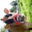

In [9]:
img_data = train[b'data'][0].reshape([32, 32, 3], order='F')
img = Image.fromarray(img_data)

img

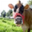

In [10]:
# x축과 y축을 바꿔서 다시 출력하기
img_data = img_data.swapaxes(0, 1)
img = Image.fromarray(img_data)

img

In [11]:
# 일단 이미지들을 저장할 하위 디렉터리를 생성한 후
# 나머지 이미지들도 reshape해서 저장한다.
# tqdm()을 사용하면 진행률을 눈으로 확인할 수 있다!
img_dir_path = os.path.join(dir_path, 'cifar-images')

if not os.path.exists(img_dir_path):
    os.mkdir(img_dir_path)

# 32x32 이미지 파일 5만개 생성
with open(train_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')
    for i in tqdm(range(len(train[b'filenames']))):
        filename = train[b'filenames'][i].decode()
        data = train[b'data'][i].reshape([32, 32, 3], order='F')
        img = Image.fromarray(data.swapaxes(0, 1))
        img.save(os.path.join(img_dir_path, filename))

100%|██████████| 50000/50000 [00:18<00:00, 2745.28it/s]


## 추가) openCV 자세히 보기
### 1) imread()
- 파일에서 이미지를 읽어온다.
- 읽어올 수 없을 경우에는 빈 행렬을 반환한다.

### 2) cvtColor()
- 컬러스페이스를 변환한다.
- ex) RGB to BGR, BGR to HSV

### 3) inRange()
- 기준이 되는 색상 범위를 받아서, 그에 해당하는 픽셀에는 1을, 그렇지 않은 것에는 0을 넣은 배열을 반환한다.
- 반환된 배열을 mask로 지정한다.

### 4) bitwise_and()
- 이미지 2장을 받아 AND 비트 연산을 한다.
- 같은 이미지를 2장 넣어서 결국 동일한 이미지가 나오도록 한다.
- 대신 mask 인자를 넣어 해당 영역만 따오도록 한다.

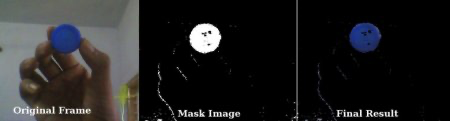

## 3. 함수 구현
### 1) draw_histogram(file_name)
- 파일명을 입력 받아 해당 이미지 파일과 히스토그램을 출력

### 2) get_histogram(img)
- 이미지의 히스토그램을 생성
- 4개 구간(0\~63, 64\~127, 128\~191, 192\~255)으로 나누어 픽셀 수를 카운트

### 3) build_histogram_db()
- 검색 대상 이미지들을 불러와서
- 히스토그램으로 만들고
- 이미지 이름(파일명)을 키로 하고, 히스토그램을 값으로 하는 딕셔너리를 반환


### 4) get_target_histogram()
- filename을 입력 받아 histogram_db에서 해당 히스토그램을 불러옴

### 5) search(histogram_db, target_histogram, top_k=5)
- openCV의 compareHist()를 이용해 입력 이미지와 검색 대상 이미지들의 히스토그램 간의 유사도를 계산
- 계산된 유사도를 기준으로 순서를 매기고 정렬
- 유사도 순서상 상위 5개의 이미지를 선정

### 6) show_result(result)
- 입력 이미지와 유사한 5개의 이미지를 보여줌

In [35]:
# 파일명을 인자로 받아 해당 이미지 파일과 히스토그램을 출력
def draw_histogram(file_name):
    img_path = os.path.join(img_dir_path, file_name)
    img = Image.open(img_path)
    cv_img = cv2.imread(img_path)
    
    # Image와 histogram 그려보기
    f = plt.figure(figsize=(10, 3))
    im1 = f.add_subplot(1, 2, 1)
    im1.imshow(img)
    im1.set_title("Image")
    
    im2 = f.add_subplot(1, 2, 2)
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        # image에서 i번째 채널의 히스토그램을 뽑아서 0:blue, 1:green, 2:red
        histr = cv2.calcHist([cv_img], [i], None, [256], [0, 256])
        
        # 그래프를 채널 색상에 맞춰서 그리기
        im2.plot(histr, color = col)
    im2.set_title("Histogram")

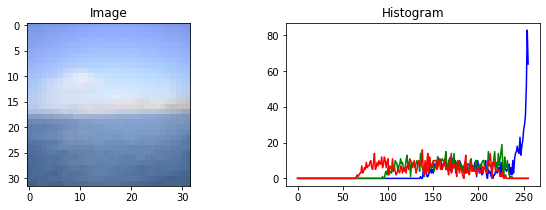

In [13]:
draw_histogram('adriatic_s_001807.png')

In [36]:
# 이미지 파일 1개에 대해 히스토그램을 만드는 함수
# 4개 구간(0~63, 64~127, 128~191, 192~255)으로 나눠 픽셀 수 세기

def get_histogram(img):
    histogram = []
    
    # 채널별로, 4 bins씩 히스토그램 생성
    for i in range(3):
        ch_histogram = cv2.calcHist(images=[img], channels=[i], mask=None, histSize=[4], ranges=[0, 256])
        histogram.append(ch_histogram)
        
    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram)
    
    return histogram

In [37]:
# get_histogram()이 잘 작동하는지 확인해보기
filename = train[b'filenames'][0].decode()
file_path = os.path.join(img_dir_path, filename)

img = cv2.imread(file_path)
histogram = get_histogram(img[0])

histogram

error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/imgproc/src/histogram.cpp:160: error: (-215:Assertion failed) j < nimages in function 'histPrepareImages'


In [19]:
def build_histogram_db():
    histogram_db = {}
    
    # 디렉터리의 이미지 파일을 전부 리스트업
    path = img_dir_path
    file_list = os.listdir(img_dir_path)
    
    for file_name in tqdm(file_list):
        file_path = os.path.join(img_dir_path, file_name)
        img = cv2.imread(file_path)
        
        histogram = get_histogram(img)
        
        histogram_db[file_name] = histogram
        
    return histogram_db

In [38]:
histogram_db = build_histogram_db()

histogram_db['adriatic_s_001807.png']

100%|██████████| 49999/49999 [00:06<00:00, 7498.27it/s]


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [22]:
def get_target_histogram():
    filename = input("이지미 파일명을 입력하세요: ")
    if filename not in histogram_db:
        print("유효하지 않은 파일명입니다.")
        return None
    return histogram_db[filename]

In [23]:
target_histogram = get_target_histogram()
target_histogram

이지미 파일명을 입력하세요: adriatic_s_001807.png


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [26]:
def search(histogram_db, target_histogram, top_k=5):
    results = {}
    
    # Calculate similarity distance by comparing histograms
    for file_name, histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1=target_histogram, H2=histogram, method=cv2.HISTCMP_CHISQR)
        
        results[file_name] = distance
    
    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])
    
    return results

In [27]:
result = search(histogram_db, target_histogram)
result

100%|██████████| 49999/49999 [00:00<00:00, 644560.57it/s]


{'adriatic_s_001807.png': 0.0,
 'baby_s_001654.png': 0.047506706444185816,
 'fogbank_s_000423.png': 0.059270738493642845,
 'tank_s_000442.png': 0.060966690827361725,
 'dessert_plate_s_000124.png': 0.06113711905561663}

In [28]:
def show_result(result):
    f = plt.figure(figsize=(10, 3))
    for idx, filename in enumerate(result.keys()):
        img_path = os.path.join(img_dir_path, filename)
        im = f.add_subplot(1, len(result), idx+1)
        img = Image.open(img_path)
        im.imshow(img)

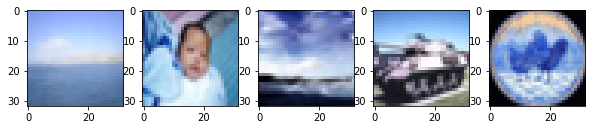

In [29]:
show_result(result)

이지미 파일명을 입력하세요: macoun_s_000598.png


100%|██████████| 49999/49999 [00:00<00:00, 629787.37it/s]


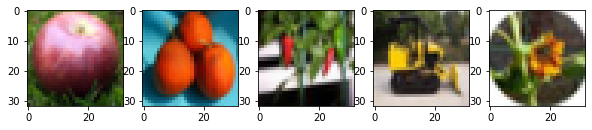

In [41]:
# main
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)

In [40]:
# 임의로 파일명 가져오기
import random

random_input = random.choice(list(histogram_db.keys()))
random_input

'macoun_s_000598.png'